Graph built with 2518 nodes and 16107 edges.
Graph too large (2518 nodes). Visualizing only the top 500 nodes.


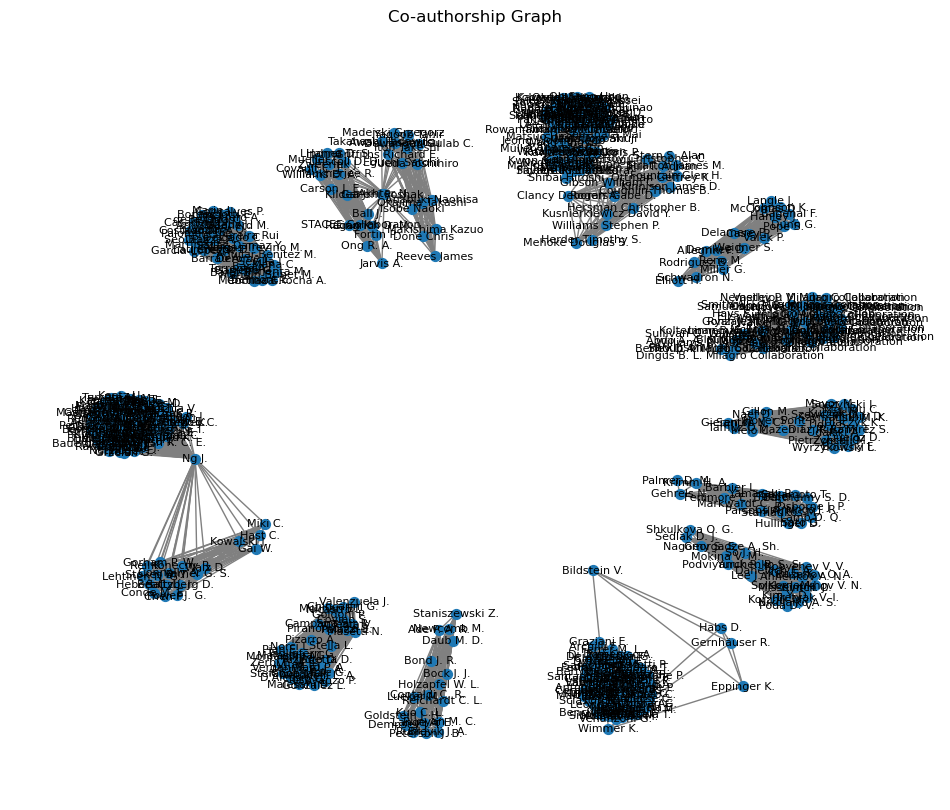

In [25]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import random

def build_coauthor_graph(jsonl_path, max_lines=None, sampling_fraction=0.05, min_degree=2):
    """
    Efficiently builds a co-authorship graph from a large JSONL file.

    Parameters:
    - jsonl_path (str): Path to the JSONL file.
    - max_lines (int, optional): Max lines to read (for debugging/sampling).
    - sampling_fraction (float, optional): Probability to sample a line (reduce memory load).
    - min_degree (int, optional): Minimum number of co-authors to keep a node.

    Returns:
    - G (networkx.Graph): The filtered co-authorship graph.
    """
    
    G = nx.Graph()
    
    with open(jsonl_path, 'r', encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            # Stop after reading max_lines (if set)
            if max_lines and i >= max_lines:
                break
            
            # Randomly sample lines to reduce memory footprint
            if random.random() > sampling_fraction:
                continue
            
            record = json.loads(line)
            raw_authors = record.get("authors_parsed", [])
            
            # Convert author names from sub-lists (["First", "Last"] -> "First Last")
            authors_list = [" ".join(filter(None, author)).strip() for author in raw_authors]
            
            # Add edges for co-authors
            for idx1 in range(len(authors_list)):
                for idx2 in range(idx1 + 1, len(authors_list)):
                    G.add_edge(authors_list[idx1], authors_list[idx2])

    # Remove nodes with degree < min_degree to reduce graph size
    low_degree_nodes = [node for node, deg in G.degree() if deg < min_degree]
    G.remove_nodes_from(low_degree_nodes)
    
    return G

def visualize_graph(G, title="Co-authorship Graph", node_limit=500, node_size=50, font_size=8):
    """
    Visualizes a subset of the co-authorship graph to avoid performance issues.
    """
    if len(G.nodes) > node_limit:
        print(f"Graph too large ({len(G.nodes)} nodes). Visualizing only the top {node_limit} nodes.")
        
        # Keep top `node_limit` authors by degree
        top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:node_limit]
        subgraph_nodes = [node for node, _ in top_nodes]
        G = G.subgraph(subgraph_nodes)

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.3)
    nx.draw_networkx(G, pos, with_labels=True, node_size=node_size, font_size=font_size, edge_color="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    # Set  JSONL file path here
    jsonl_path = "/Users/thomas/arxiv-metadata-oai-snapshot.json"
    
    # Build the co-authorship graph efficiently
    G = build_coauthor_graph(
        jsonl_path=jsonl_path, 
        max_lines=50000,  # Limit to 50K lines for faster testing (set None to read all)
        sampling_fraction=0.02,  # Process 2% of lines
        min_degree=2  # Remove low-degree authors
    )

    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Visualize the graph only if it's small enough
    visualize_graph(G, node_limit=500)


Graph built with 1105 nodes and 4990 edges.
Graph too large (1105 nodes). Visualizing only the top 200 nodes.


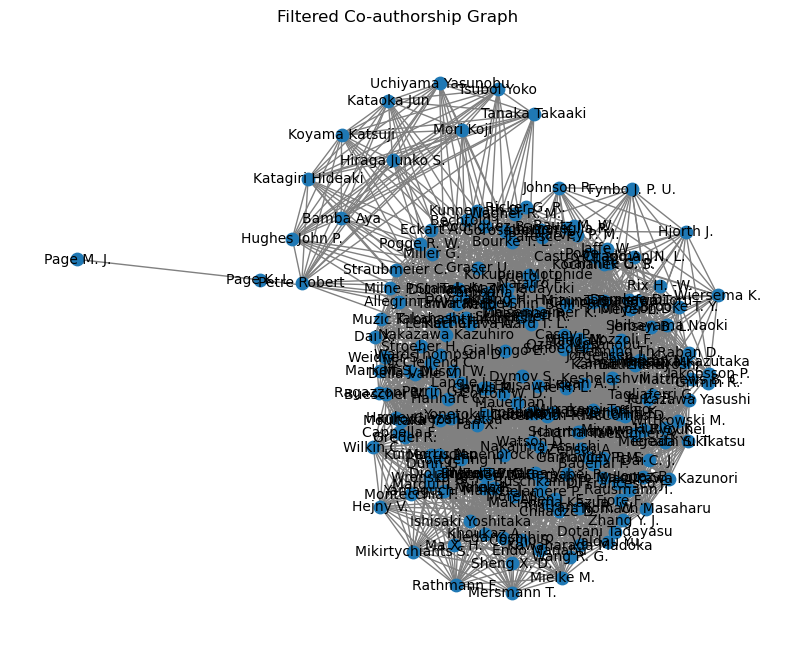

In [27]:
#try to decrease the nodes to top 200
import json
import networkx as nx
import matplotlib.pyplot as plt
import random

def build_coauthor_graph(jsonl_path, max_lines=None, sampling_fraction=0.02, min_degree=3):
    """
    Efficiently builds a co-authorship graph while filtering low-degree nodes.
    
    Parameters:
    - jsonl_path (str): Path to the JSONL file.
    - max_lines (int, optional): Limit number of lines read (for performance).
    - sampling_fraction (float, optional): Fraction of lines to sample (reduce memory load).
    - min_degree (int, optional): Minimum number of co-authors to keep a node.

    Returns:
    - G (networkx.Graph): The co-authorship graph.
    """
    
    G = nx.Graph()
    
    with open(jsonl_path, 'r', encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            if max_lines and i >= max_lines:
                break  # Stop early if max_lines is set
            
            if random.random() > sampling_fraction:
                continue  # Randomly sample lines
            
            record = json.loads(line)
            raw_authors = record.get("authors_parsed", [])
            
            authors_list = [" ".join(filter(None, author)).strip() for author in raw_authors]
            
            # Add edges for co-authors
            for idx1 in range(len(authors_list)):
                for idx2 in range(idx1 + 1, len(authors_list)):
                    G.add_edge(authors_list[idx1], authors_list[idx2])

    # Remove nodes with degree < min_degree
    low_degree_nodes = [node for node, deg in G.degree() if deg < min_degree]
    G.remove_nodes_from(low_degree_nodes)
    
    return G

def visualize_graph(G, title="Filtered Co-authorship Graph", node_limit=300, node_size=80, font_size=10):
    """
    Visualizes a subset of the co-authorship graph.
    - Uses `kamada_kawai_layout` for better spacing.
    - Filters top `node_limit` most connected authors.
    """
    if len(G.nodes) > node_limit:
        print(f"Graph too large ({len(G.nodes)} nodes). Visualizing only the top {node_limit} nodes.")
        
        # Keep top `node_limit` authors by degree
        top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:node_limit]
        subgraph_nodes = [node for node, _ in top_nodes]
        G = G.subgraph(subgraph_nodes)

    plt.figure(figsize=(10, 8))
    pos = nx.kamada_kawai_layout(G)  # Better spacing than spring layout
    nx.draw_networkx(G, pos, with_labels=True, node_size=node_size, font_size=font_size, edge_color="gray")
    
    plt.title(title)
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    jsonl_path = "/Users/thomas/arxiv-metadata-oai-snapshot.json"
    
    # Adjusting parameters to further filter out weakly connected authors
    G = build_coauthor_graph(
        jsonl_path=jsonl_path, 
        max_lines=50000,  # Limit for faster processing
        sampling_fraction=0.02,  # Only take 2% of data
        min_degree=4  # Keep only authors with at least 4 co-authors
    )

    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Visualize with a reduced number of nodes
    visualize_graph(G, node_limit=200)  # Reduced to 200 nodes


Graph built with 764 nodes and 6942 edges.
Graph too large (764 nodes). Visualizing only the top 50 nodes.


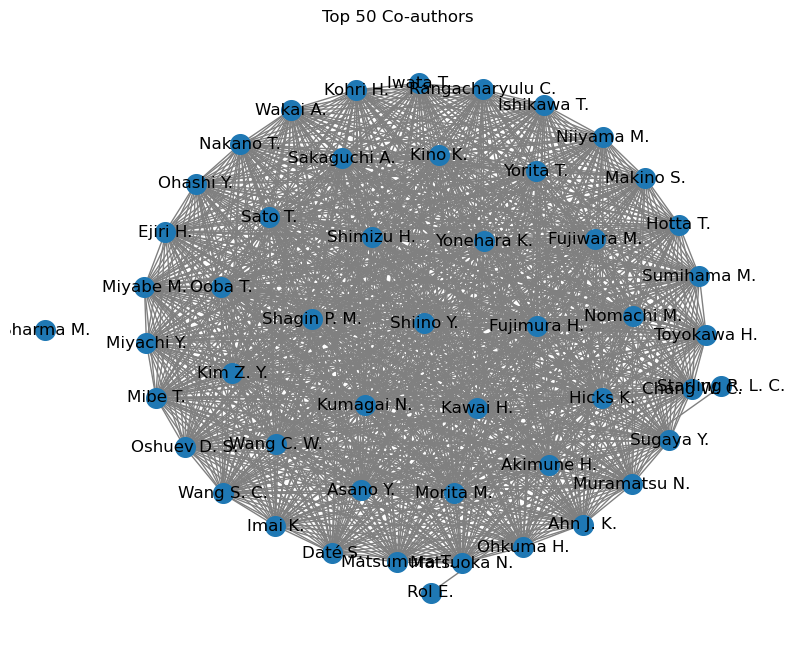

In [31]:
#try to decrease the nodes to top 50
import json
import networkx as nx
import matplotlib.pyplot as plt
import random

def build_coauthor_graph(jsonl_path, max_lines=None, sampling_fraction=0.02, min_degree=5):
    """
    Efficiently builds a co-authorship graph while filtering low-degree nodes.
    
    Parameters:
    - jsonl_path (str): Path to the JSONL file.
    - max_lines (int, optional): Limit number of lines read (for performance).
    - sampling_fraction (float, optional): Fraction of lines to sample (reduce memory load).
    - min_degree (int, optional): Minimum number of co-authors to keep a node.

    Returns:
    - G (networkx.Graph): The co-authorship graph.
    """
    
    G = nx.Graph()
    
    with open(jsonl_path, 'r', encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            if max_lines and i >= max_lines:
                break  # Stop early if max_lines is set
            
            if random.random() > sampling_fraction:
                continue  # Randomly sample lines
            
            record = json.loads(line)
            raw_authors = record.get("authors_parsed", [])
            
            authors_list = [" ".join(filter(None, author)).strip() for author in raw_authors]
            
            # Add edges for co-authors
            for idx1 in range(len(authors_list)):
                for idx2 in range(idx1 + 1, len(authors_list)):
                    G.add_edge(authors_list[idx1], authors_list[idx2])

    # Remove nodes with degree < min_degree
    low_degree_nodes = [node for node, deg in G.degree() if deg < min_degree]
    G.remove_nodes_from(low_degree_nodes)
    
    return G

def visualize_graph(G, title="Top 50 Co-authors", node_limit=50, node_size=200, font_size=12):
    """
    Visualizes a subset of the co-authorship graph.
    - Focuses only on the **top 50** most connected authors.
    - Uses `kamada_kawai_layout` for better node placement.
    """
    if len(G.nodes) > node_limit:
        print(f"Graph too large ({len(G.nodes)} nodes). Visualizing only the top {node_limit} nodes.")
        
        # Keep top `node_limit` authors by degree
        top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:node_limit]
        subgraph_nodes = [node for node, _ in top_nodes]
        G = G.subgraph(subgraph_nodes)

    plt.figure(figsize=(10, 8))
    pos = nx.kamada_kawai_layout(G)  # Better spacing than spring layout
    nx.draw_networkx(G, pos, with_labels=True, node_size=node_size, font_size=font_size, edge_color="gray")
    
    plt.title(title)
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    jsonl_path = "/Users/thomas/arxiv-metadata-oai-snapshot.json"
    
    # Adjust parameters to filter more aggressively
    G = build_coauthor_graph(
        jsonl_path=jsonl_path, 
        max_lines=50000,  # Process 50K lines
        sampling_fraction=0.02,  # Sample 2% of lines
        min_degree=6  # Only authors with 6+ co-authors
    )

    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Visualize only the top 50 nodes
    visualize_graph(G, node_limit=50)
